<a href="https://colab.research.google.com/github/Jules-gatete/Intro_to_ML---Summatives/blob/main/Summative_Intro_to_ml_Jules_Gatete_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

In [10]:
# Load the dataset
file_path = "/content/Drug prescription Dataset.csv"
df = pd.read_csv(file_path)

In [12]:
# Display basic info
print(df.head())

    disease  age gender severity                drug
0  diarrhea    4   male      LOW  promegranate drink
1  diarrhea    4   male   NORMAL          lime juice
2  diarrhea    5   male      LOW  promegranate drink
3  diarrhea    5   male   NORMAL          lime juice
4  diarrhea    6   male      LOW  promegranate drink


In [3]:
df.describe()

,age
count,1288.000000
mean,33.645963
std,15.532570
min,4.000000
25%,20.000000
50%,34.000000
75%,47.000000
max,60.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1288 non-null   object
 1   age       1288 non-null   int64 
 2   gender    1288 non-null   object
 3   severity  1288 non-null   object
 4   drug      1288 non-null   object
dtypes: int64(1), object(4)
memory usage: 50.4+ KB


disease     0
age         0
gender      0
severity    0
drug        0
dtype: int64


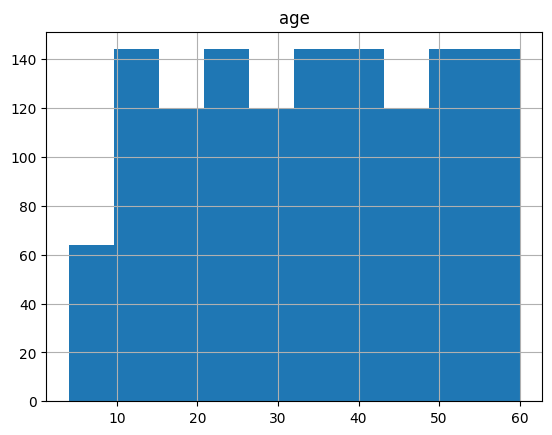

In [5]:
missing_values = df.isnull().sum()
print(missing_values)

# Plot the distribution of the data
df.hist()
plt.show()

In [13]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ["disease", "gender", "severity", "drug"]

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split dataset into features and target variable
X = df.drop(columns=["drug"])
y = df["drug"]

In [20]:
# Split dataset into features and target variable
X = df.drop(columns=["drug"])  # Features
y = df["drug"]  # Target variable

# Step 1: Split into 60% training and 40% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Step 2: Ensure stratification is only used if class count >1
class_counts = y_temp.value_counts()
stratify_param = y_temp if class_counts.min() >= 2 else None

# Step 3: Split the 40% temporary set into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=stratify_param)

# Scale only numerical features (age) & keep DataFrame structure
scaler = StandardScaler()
for dataset in [X_train, X_val, X_test]:  # Apply the same transformation
    dataset["age"] = scaler.fit_transform(dataset[["age"]])

# Print dataset sizes
dataset_sizes = {
    "Training data": X_train.shape[0],
    "Validation data": X_val.shape[0],
    "Testing data": X_test.shape[0]
}

print(f"Training data: {X_train.shape[0]} samples")
print(f"Validation data: {X_val.shape[0]} samples")
print(f"Testing data: {X_test.shape[0]} samples")


Training data: 772 samples
Validation data: 258 samples
Testing data: 258 samples


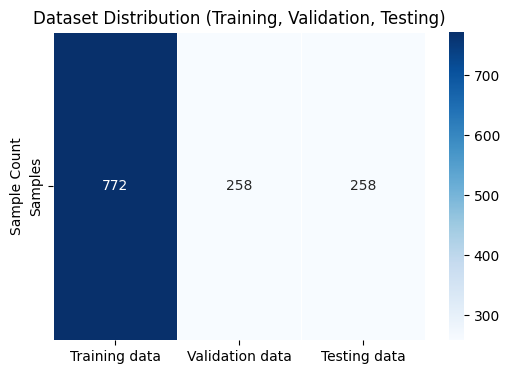

In [22]:
# Convert dataset sizes to a dataframe for visualization
df_sizes = pd.DataFrame(dataset_sizes.items(), columns=["Dataset", "Samples"])

# Plot dataset distribution using heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_sizes.set_index("Dataset").T, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Dataset Distribution (Training, Validation, Testing)")
plt.xlabel("")
plt.ylabel("Sample Count")
plt.show()

Training data: 772 samples
Validation data: 258 samples
Testing data: 258 samples


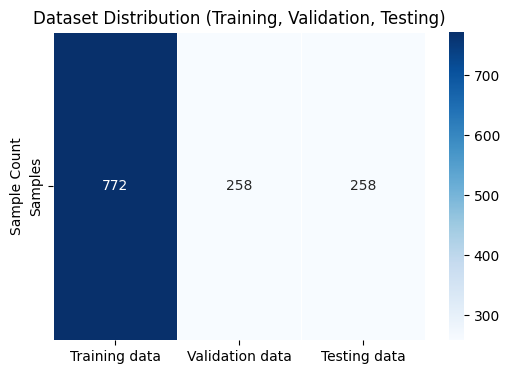

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert dataset sizes to a dataframe for visualization
df_sizes = pd.DataFrame(dataset_sizes.items(), columns=["Dataset", "Samples"])

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_sizes.set_index("Dataset").T, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Dataset Distribution (Training, Validation, Testing)")
plt.xlabel("")
plt.ylabel("Sample Count")
plt.show()


# 📌 Function to train and evaluate models


In [23]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"\n📊 Performance Metrics - {model_name}:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", xticklabels=False, yticklabels=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return metrics


## Logistic Regression (Classical ML)


In [ ]:


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


df.head()
print(df.dtypes)

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0)
log_reg.fit(X_train_scaled, y_train)
log_reg_metrics = evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")

## Simple Neural Network (No Optimization) =




In [ ]:
simple_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])
simple_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
simple_nn_metrics = evaluate_model(simple_nn, X_test_scaled, y_test, "Simple Neural Network")


# Optimized Neural Networks

## Model 1: Adam Optimizer + L1 Regularization


In [ ]:
adam_l1_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(len(np.unique(y)), activation='softmax')
])
adam_l1_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
adam_l1_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
adam_l1_metrics = evaluate_model(adam_l1_model, X_test_scaled, y_test, "Adam + L1 Regularization")

## Model 2: RMSProp Optimizer + L2 Regularization

In [ ]:

rmsprop_l2_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(np.unique(y)), activation='softmax')
])
rmsprop_l2_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rmsprop_l2_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
rmsprop_l2_metrics = evaluate_model(rmsprop_l2_model, X_test_scaled, y_test, "RMSProp + L2 Regularization")

## Model 3: SGD Optimizer + L1 Regularization


In [ ]:
sgd_l1_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(0.01), input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    Dense(len(np.unique(y)), activation='softmax')
])
sgd_l1_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sgd_l1_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
sgd_l1_metrics = evaluate_model(sgd_l1_model, X_test_scaled, y_test, "SGD + L1 Regularization")